# Notebook 1

Notebook summarising how we discovered inversions.

# Input data processing

The pipeline will start from filtered bcf files, one for each of the 21
chromosomes.

Below is the steps that I followed to get from the raw sequence files to
these bcf files.

## Mapped reads to the reference

### The reference genome

<https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000002235.5/>

N50: 37.3 Mb

### The mapping algorithm

Input: List of read files (R1 and R2)

```bash
while read line ; do
        F1=$(cut -d ' ' -f1 <<< $line)
        F2=$(cut -d ' ' -f2 <<< $line)
        echo "$F1 -- $F2"
        FILE=$(mktemp)
        cat header.txt >> $FILE
        echo "spack load samtools@1.10" >> $FILE
        echo "spack load bwa@0.7.17" >> $FILE
        ref="/users/c/p/cpetak/WGS/reference_genome/GCF_000002235.5_Spur_5.0_genomic.fna"
        out_name=$(cut -d '.' -f1 <<< $F1)
        echo "bwa mem -t 1 -M $ref /users/c/p/cpetak/WGS/all_fastqs/$F1 /users/c/p/cpetak/WGS/all_fastqs/$F2 | samtools view -S -b > /users/c/p/cpetak/WGS/BWA_out/$out_name.bam" >> $FILE
        sbatch $FILE
        sleep 0.5
        rm $FILE
done < $1
```

The Burrows-Wheeler Alignment Tool (BWA) MEM algorithm was used for
mapping the raw reads to the S. purpuratus reference genome (Spur ver.
5.0, scaffold N50 ∼37 Mbp). The average coverage for each individual was
6.42±0.78, with an average mapping rate of 81.6±0.01.

## Called variants for each chromosome across all individuals

Input:

-   21 chromosome names
-   list_of_files.txt, 140 lines, line 1:
    `/users/c/p/cpetak/WGS/BWA_out/BOD_18170X61_200925_A00421_0244_AHKML5DSXY_S81_L002_R1_001.rmdup.bam`

```bash
while read line ; do
	echo "$line"
	FILE=$(mktemp)
  cat header.txt >> $FILE
  ref="/users/c/p/cpetak/WGS/reference_genome/GCF_000002235.5_Spur_5.0_genomic.fna"
  echo "echo "${line}" " >> $FILE
  echo "bcftools mpileup -r $line -f $ref --bam-list list_of_files.txt | bcftools call -mv -Ob -o multi_bam_${line}.bcf" >> $FILE
  sbatch $FILE
  sleep 0.5
  rm $FILE
done < $1
```

## Filtering the bcf files

```bash
#!/bin/sh

mychr="NW_022145594.1"
myfolder="/users/c/p/cpetak/EG2023/structural_variation/bcf_files"
suppfolder="/users/c/p/cpetak/WGS/local_pca_pipe/supp_files"

#pre filter: 10.854.890

bcftools view -e 'QUAL <= 40 || DP < 560 || MQB < -3 || RPB < -3 || RPB > 3 || AN < 238' ${myfolder}/multi_bam_${mychr}.bcf > ${myfolder}/${mychr}_filtered.vcf
#note: after each step, the output is vcf, which needs to be converted into bcf
bcftools view -Ob ${myfolder}/${mychr}_filtered.vcf > ${myfolder}/${mychr}_filtered.bcf

#post first filter (aka old filtering): 3.999.255

# taking out 3 outliers: CAP_18170X101, FOG_18170X127 and FOG_18170X128
bcftools view -S ${suppfolder}/all_rmdups_noout.txt -o ${myfolder}/${mychr}_filtered_noout.vcf ${myfolder}/${mychr}_filtered.bcf
# Allele count in genotypes for each ALT allele, keep only SNPs, and only biallelic:
bcftools view -e 'AC < 14' --exclude-types 'indels,mnps,ref,bnd,other' -m2 -M2 ${myfolder}/${mychr}_filtered.bcf > ${myfolder}/${mychr}_filtered_noout.vcf
# remove repetitive elements:
#found a paper that used RepeatModeler 2.0.1 to find repetitive regions in the Spur assembly (same as what we are using here) - took their dataset and removed any variations that fell within any of those regions. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8615465/#:~:text=Repetitive%20elements%20(REs)%20occupy%20a,of%20biological%20processes%20remains%20unknown

bcftools view -T ^${suppfolder}/Spur_repeats_02 ${myfolder}/${mychr}_filtered.bcf -o ${myfolder}/${mychr}_filtered_noout.vcf

#post second filter: 402.500

# Convert the filtered vcf into the bcf file type which is the type the R package will be expecting

bcftools view -Ob ${myfolder}/${mychr}_filtered.vcf > ${myfolder}/${mychr}_filtered.bcf

# Index the filtered bcf file. This will make the file more searchable by the algorythm reading it.

bcftools index ${myfolder}/${mychr}_filtered.bcf
```

Output: bcf files in the
`/users/c/p/cpetak/EG2023/structural_variation/filtered_bcf_files`
directory.

# Running lostruct

On the github page, they provide an Rscript to show how to use the package. I copied this:
[run_lostruct.R](https://github.com/Cpetak/local_pca_pipe/blob/main/run_lostruct.R)

No changes, expect output folder has chromosome name instead of random id.

```bash     
#conda activate grn
#spack load bcftools@1.10.2

echo "Chromosome number: $1"

input_dir="/users/c/p/cpetak/EG2023/structural_variation/filtered_bcf_files/${1}"

echo $input_dir

for snp in 500 1000 5000 10000
do
    echo "$snp"
    FILE=$(mktemp)
    cat header.txt >> $FILE
    echo "Rscript ~/WGS/local_pca_pipe/run_lostruct.R -i ${input_dir} -t snp -s ${snp} -I ~/WGS/local_pca_pipe/sample_info.tsv -c ${1}" >> $FILE
    sbatch $FILE
    #cat $FILE
    sleep 0.1
    rm $FILE
done
```

To run: `bash 2_1_local_pca.sh NW_022145594.1`

## Visualise and gather data

They also have an example of plotting the data, I copied this as well.
[summarize_run.Rmd](https://github.com/Cpetak/local_pca_pipe/blob/main/summarize_run.Rmd)

Changes:

-   do.pdfs \<- TRUE in line 14,

-   commented out warning in line 78, breaks code otherwise

-   added saving of corner pcas

-   added getting the percent corner (i.e. alpha) as a variable read
    from a file

Once the 2.1 script finishes, you should have a folder called lostruct_results and a folder in it, named type_snp_size_10000_chromosome_NW_022145594.1.

```bash
#conda activate grn
#spack load bcftools@1.10.2

echo "Chromosome number: $1"
echo "Type: $2"
echo "Size: $3"
echo "Percent corner: $4"

input_dir="/users/c/p/cpetak/EG2023/structural_variation/filtered_bcf_files/${1}"

echo $input_dir

cd ~/WGS/inversion_results/lostruct_results/type_${2}_size_${3}_chromosome_${1}
echo $4 > percent_file.txt #the R script below will be looking for this file! easier than figuring out how to pass in as an argument

cd ~/WGS/inversion_results

FILE=$(mktemp)
cat header.txt >> $FILE
echo "Rscript -e 'templater::render_template(\"~/WGS/local_pca_pipe/summarize_run.Rmd\",output=\"~/WGS/inversion_results/lostruct_results/type_${2}_size_${3}_chromosome_${1}/run_summary.html\",change.rootdir=TRUE)'" >> $FILE
sbatch $FILE
#cat $FILE
sleep 0.1
rm $FILE
```

To run: `bash 2_2_local_pca_vis.sh NW_022145594.1 snp 10000 0.01` It is chromosome, type, size, alpha (percent outliers considered). 
To run for every snp length independently, a one-line:
`for snp in 500 1000 5000 10000; do bash 2_2_local_pca_vis.sh NW_022145594.1 snp $snp 0.05; done`

Then can rerun specific ones to adjust alpha.

Local PCA results after first filtering step (~4 million sites in the bcf)

<img src="2024-07-11-12-20-49.png" width="800">

PCA of outlier (orange) windows combined using the local PCA package:

<img src="2024-07-11-12-23-26.png" width="400">

After second filtering, the same plots:

<img src="2024-07-11-12-26-35.png" width="800"><br>
<img src="2024-07-11-12-27-46.png" width="400">

Like for other filtering, 16 on the left, 40 on the right group

## Finding regions of interest

Automated way of finding the genomic coordinates of the outlier regions.

INPUT: MDS output files for a specific chromosome, for a specific type of window size (snp vs bp)

Python file, conda activate wgs, [finding_outlier_windows.py](https://github.com/Cpetak/local_pca_pipe/blob/main/finding_outlier_windows.py)

To run: `python finding_outlier_windows.py NW_022145594.1 snp`

You can add an optional argument `--thr 0.2` to adjust the MDS outlier threshold.

OUTPUT: Outlier region genomic coordinates for a specific chromosome for each window size tested.

For NW_022145594.1, two spikes, (from 500 snp window data, all filtering): 

**12702886-16793794 whole region, first spike: 12702886 - 13424367, second spike: 15422748-16793794**

Note: 12703097-16386233 with older filtering, 12703097-13347295, 15400136-16386233


## Grouping individuals by genotype for specific region

INPUT: Coordinates of region of interest, bcf file of chromosome

Now that we have regions of interest (to recap: local pca -\> mds values
-\> outlier region coordinates) we should first look at the PCA of the
individuals based on that region. Yes, technically, this is what local
PCA is doing already, but it is cleaner and safer to start fresh from
the bcf files and do our own, independent PCA. The result should be the
same or similar! it might not be exactly the same because the PCAs that
are plotted as part of the local PCA pipe line only include outlier
windows, whereas here we are going to take all SNPs in a specific region
for the PCA analysis, and this might include windows that were not
outliers in the local PCA analysis.

For all of the steps below, conda activate wgs. (grn is for local PCA and LD only)

### Step 1: Make a vcf file that only includes the region of interest for
our chromosome.

```bash
chrom=$1
mystart=$2
myend=$3

input_vcf="/users/c/p/cpetak/EG2023/structural_variation/filtered_bcf_files/${chrom}/${chrom}_filtered.vcf"

grep -v \# $input_vcf | awk -v myvariable=$mystart '$2 >= myvariable' | awk -v myvariable=$myend '$2 <= myvariable' > temp.vcf

outfilename=${1}_${2}_${3}.vcf
cat vcf_header_noout temp.vcf > $outfilename

rm temp.vcf
```

run: `bash subset_bcf.sh NW_022145594.1 12670717 16440127` where it is
chromosome, start, end. Looks for a vcf file in the common data folder
for that chromosome (EG2023), output is also a vcf in the curr directory

### Step 2: Convert vcf to gds

```bash
library(SeqArray)
library(SNPRelate)

seqParallelSetup(cluster=10, verbose=TRUE)

args <- commandArgs(trailingOnly = TRUE)
vcf_file <- args[1]
out_file <- args[2]

print(args)
#print(paste(args[1],"sometime"))

snpgdsVCF2GDS(vcf_file,paste(out_file,".gds",sep=""),verbose=T)
```

run:
`Rscript vcf2gds.R NW_022145594.1_12670717_16440127.vcf NW_022145594.1_12670717_16440127`
input filename, output file name (it will add .gds)

### Step 3: Do PCA from the gds file

```R
library("SNPRelate")

args <- commandArgs(trailingOnly = TRUE)
filename <- args[1]
genofile <- snpgdsOpen(filename)

ccm_pca<-snpgdsPCA(genofile, autosome.only=FALSE)
dim1<-ccm_pca$eigenvect[,1]
dim2<-ccm_pca$eigenvect[,2]

eigenval_list <- ccm_pca$eigenval
eigenval_list[is.nan(eigenval_list)] <- 0
esum <- sum(eigenval_list)
e1 <- eigenval_list[1] / esum * 100
e2 <- eigenval_list[2] / esum * 100

my_df1 <- as.data.frame(dim1)
my_df2 <- as.data.frame(dim2)

special_character <- "\\."
split_string <- strsplit(filename, special_character)[[1]]
result1 <- paste(paste(head(split_string, -1), collapse = "."),"_dim1.csv",sep="")
result2 <- paste(paste(head(split_string, -1), collapse= "."),"_dim2.csv",sep="")

eresult <- paste(paste(head(split_string, -1), collapse= "."),"_perc_explained.csv",sep="")

writeLines(c(as.character(e1), as.character(e2)), eresult)

write.csv(my_df1, result1, row.names=FALSE)
write.csv(my_df2, result2, row.names=FALSE)
```

run: `Rscript do_pca.R NW_022145594.1_12670717_16440127.gds` does PCA
and writes PC1 and PC2 to csv files.

### Step 4: Assign individuals to genotype groups, make plots

Python file, [genotype_by_PCA.py](https://github.com/Cpetak/local_pca_pipe/blob/main/genotype_by_PCA.py)

run:
`python genotype_by_PCA.py NW_022145594.1_12670717_16440127_dim1.csv NW_022145594.1_12670717_16440127_dim2.csv 3 NW_022145594.1_12670717_16440127_perc_explained.csv`,
`python genotype_by_PCA.py NW_022145594.1_12702886_16793794_dim1.csv NW_022145594.1_12702886_16793794_dim2.csv 3 NW_022145594.1_12702886_16793794_perc_explained.csv`
3 is number of clusters, output is 2 csv files with individual IDs
(1-140) for each homozygote group and PCA, elbow, pie, line and map
plots, and chi-square results to txt file

OUT: AA, Aa or aa for each individual and PCA plot, with map

PCA from bcf file restricted to the region between and including the two spikes on the MDS plot:

With region 12703097-16386233 determined by old filtering and on data filtered the old way (aka only first line of filtering)

<img src="2024-07-11-12-24-57.png" width="400">

With region 12702886-16793794 determined by new filtering and on data filtered the new way

<img src="2024-10-22-16-12-24.png" width="400">

Note: rest of the results will be all using the new filtering.

Left breakpoint only: 12702886_13424367

<img src="2024-12-15-21-17-20.png" width="400">

Right breakpoint only: 15422748_16793794 (and _16343794 adjusted based on Fst results )

<img src="2024-12-15-21-22-02.png" width="400">

<img src="2024-12-17-14-47-30.png" width="400">

Middle of inversion, between 14 and 15 Mbp

<img src="2024-12-15-21-30-13.png" width="400">

Num homop = 40, num homoq = 16, num heterozygotes = 81.

Checking if more heterozygotes than expected: 

- p-val = 0.036, 
- expected homozygotes/observed homozygotes (q) = 1.456, 
- expected homozygotes/observed homozygotes (p) = 1.182,
- expected heterozygotes / observed heterozygotes (2pq) = 0.819. since less than one, observed is more than expected.

Purple: hetero, green p, yellow q. More hetero in the South!

<img src="2024-07-11-16-13-11.png" width="400"><br>

<img src="2024-10-22-16-26-36.png" width="600"><br>

<img src="2024-10-22-15-58-08.png" width="600">

0.7479186111632871 0.05320938828657739


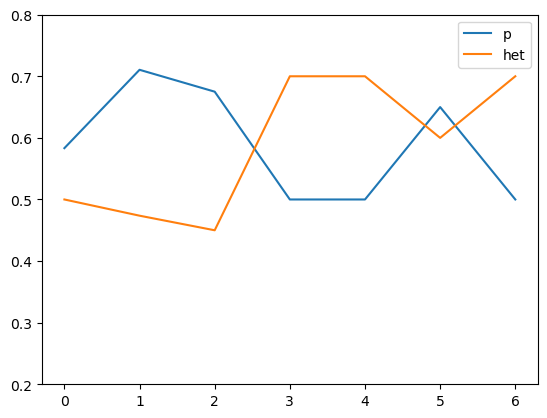

In [ ]:
#below is now part of genotype_by_pca

'''
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

het_freqs = np.array([0.5, 0.47368421, 0.45, 0.7, 0.7, 0.6, 0.7])
homop_freqs = np.array([0.33333333, 0.47368421, 0.45, 0.15, 0.15, 0.35, 0.15])
p_freq = het_freqs/[2] + homop_freqs
plt.plot(p_freq, label="p")
plt.plot(het_freqs, label="het")
plt.ylim(0.2, 0.8)
plt.legend()

slope, intercept, r_value, p_value, std_err = stats.linregress(list(range(len(het_freqs))), het_freqs)
print(r_value, p_value)
'''

To calculate heterozygocity for each group:

`spack load vcftools@0.1.14`

`vcftools --vcf NW_022145594.1_hetero.vcf --het --out NW_022145594.1_hetero_heterozygocity`

For each individual, gives observed and expected homozygocity

But first, specify inversion region:

`vcftools --vcf NW_022145594.1_hetero.vcf --chr NW_022145594.1 --from-bp 12702886 --to-bp 16793794 --recode --out NW_022145594.1_hetero_onlyinv.vcf`

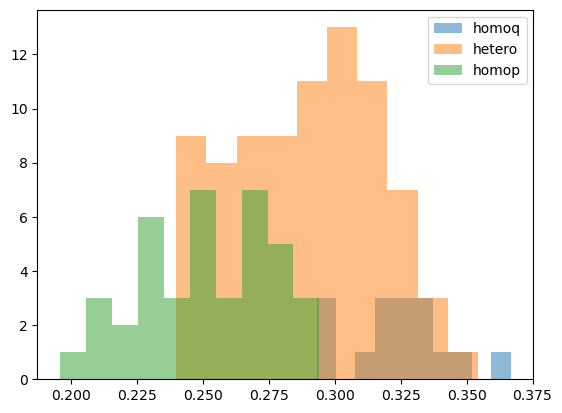

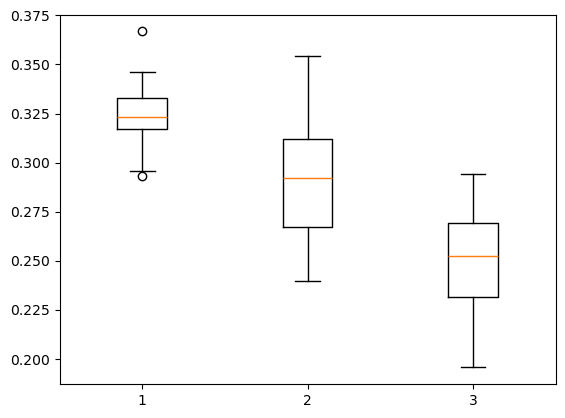

In [13]:
import os
import pandas as pd
import matplotlib.pyplot as plt
vals=[]
for i in ["homoq","hetero", "homop"]:
    file_path = os.path.expanduser(f'~/NW_022145594.1_{i}_heterozygocity.het')
    df = pd.read_csv(file_path, delimiter='\t')
    df["het"] = 1 - (df["O(HOM)"] / df["N_SITES"]) #number of homozygous sites / all sites is homozygocity
    vals.append(df["het"].to_list())
    plt.hist(df.het.to_list(), label = i, alpha = 0.5)
plt.legend()
plt.show()
plt.boxplot(vals)
plt.show()

## Calculating Fst between the two homozygote groups

INPUT: Individual IDs for the two homozygote groups, bcf file of the
chromosome, determined in the genotyping step above.

(Need `vcf_col_ids` which is a list of column names in the vcf file
corresponding to the individuals. Can be generated by
`bcftools query -l NW_022145594.1_filtered.vcf > vcf_col_ids`)

### Step 1: Column IDs in the vcf file belonging to p and q
```bash
#!/bin/bash

file_path="vcf_col_ids"

if [ $2 == 3 ]; then
file_homop="${1}_homop_nums.txt"
file_homoq="${1}_homoq_nums.txt"

homop=()
while IFS= read -r line; do
  homop+=("$line")
done < $file_homop

homoq=()
while IFS= read -r line; do
      homoq+=("$line")
    done < $file_homoq

for row_number in "${homop[@]}"; do
  sed -n "${row_number}p" "$file_path" >> "${1}_vcf_list_homop"
done

for row_number in "${homoq[@]}"; do
    sed -n "${row_number}p" "$file_path" >> "${1}_vcf_list_homoq"
done

else

for c in $(seq 0 $2)
do
  echo "number $c"
  myfile="${1}_clust${c}.txt"
  geno=()
  while IFS= read -r line; do
    geno+=("$line")
  done < $myfile
  for row_number in "${geno[@]}"; do
    sed -n "${row_number}p" "$file_path" >> "${1}_vcf_list_clust${c}"
  done

done
fi
```

`chr=NW_022145594.1`
`fname=NW_022145594.1_39429440_42445994`

run: `bash extract_inds_from_vcf.sh ${fname} 4`, 4 is number of clusters minus 1 (except if it's 3, then write 3), output is NW_022145594.1_12670717_16440127_vcf_list_homop and
NW_022145594.1_12670717_16440127_vcf_list_homoq for 3 clusters or clust0...4 for 5 clusters which are lists of vcf column names to keep for each group

### Step 2: Run Fst calculation

spack load vcftools@0.1.14

`vcftools --gzvcf ~/EG2023/structural_variation/backup/filtered_vcf/NW_022145594.1_filtered.vcf --weir-fst-pop NW_022145594.1_12670717_16440127_vcf_list_homoq --weir-fst-pop NW_022145594.1_12670717_16440127_vcf_list_homop --out NW_022145594.1_12670717_16440127_fst`


`vcftools --gzvcf ~/EG2023/structural_variation/backup/filtered_vcf/${chr}_filtered.vcf --weir-fst-pop ${fname}_vcf_list_homoq --weir-fst-pop ${fname}_vcf_list_homop --out ${fname}_fst`

### Step 3: Plot Fst results

```python
import pandas as pd
import matplotlib.pyplot as plt
import argparse

parser = argparse.ArgumentParser(description="Description of your script")
parser.add_argument("chr", type=str, help="Chromosome name")
parser.add_argument("start", type=int, help="start region")
parser.add_argument("stop", type=int, default=0.1, help="stop region")
args = parser.parse_args()

filename="~/WGS/inversion_results/" + args.chr + "_" + str(args.start) + "_" + str(args.stop) + "_fst.weir.fst"
df=pd.read_csv(filename, sep="\t")

fig, ax1 = plt.subplots(figsize=(16, 8))
plt.plot(df["POS"], df["WEIR_AND_COCKERHAM_FST"], ".")
plt.ylabel("Fst, homo1 vs homo2")
plt.xlabel("Genomic position")

plt.savefig(args.chr + "_" + str(args.start) + "_" + str(args.stop) + "fst_plot.jpg")
```

`python fst_plotting.py NW_022145594.1 12670717 16440127`

OUTPUT: Fst value for each position in the chromosome, and Fst plot

<img src="2024-07-11-17-08-29.png" width="800">